In [1]:
!pip3 install keras


[notice] A new release of pip is available: 23.0 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


Shopify (SHOP) Stock Prediction

In [2]:
import yfinance as yf

shop = yf.Ticker("SHOP")
shop_hist = shop.history(period="max")

In [3]:
shop_hist.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-05-20 00:00:00-04:00,1.700,1.700,1.700,1.700,0,0.0,0.0
2015-05-21 00:00:00-04:00,2.800,2.874,2.411,2.568,123039000,0.0,0.0
2015-05-22 00:00:00-04:00,2.607,3.110,2.600,2.831,28412000,0.0,0.0
2015-05-26 00:00:00-04:00,2.980,3.034,2.908,2.965,8202000,0.0,0.0
2015-05-27 00:00:00-04:00,3.067,3.081,2.700,2.750,7976000,0.0,0.0


<AxesSubplot:xlabel='Date'>

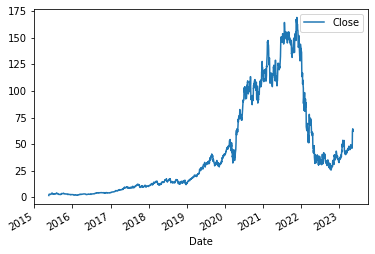

In [4]:
shop_hist.plot.line(y="Close", use_index=True)

Preparing Data

In [5]:
data = shop_hist[["Close"]]
data = data.rename(columns = {'Close':'Actual_Close'})
data["Target"] = shop_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

In [6]:
data.head(5)

,Actual_Close,Target
Date,,
2015-05-20 00:00:00-04:00,1.700,NaN
2015-05-21 00:00:00-04:00,2.568,1.0
2015-05-22 00:00:00-04:00,2.831,1.0
2015-05-26 00:00:00-04:00,2.965,1.0
2015-05-27 00:00:00-04:00,2.750,0.0


In [7]:
shop_prev = shop_hist.copy()

In [8]:
shop_prev = shop_prev.shift(1)

In [9]:
shop_prev.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-05-20 00:00:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-21 00:00:00-04:00,1.700,1.700,1.700,1.700,0.0,0.0,0.0
2015-05-22 00:00:00-04:00,2.800,2.874,2.411,2.568,123039000.0,0.0,0.0
2015-05-26 00:00:00-04:00,2.607,3.110,2.600,2.831,28412000.0,0.0,0.0
2015-05-27 00:00:00-04:00,2.980,3.034,2.908,2.965,8202000.0,0.0,0.0


In [10]:
predictors = ["Close", "High", "Low", "Open", "Volume"]
data = data.join(shop_prev[predictors]).iloc[1:]

In [11]:
data.head(5)

,Actual_Close,Target,Close,High,Low,Open,Volume
Date,,,,,,,
2015-05-21 00:00:00-04:00,2.568,1.0,1.700,1.700,1.700,1.700,0.0
2015-05-22 00:00:00-04:00,2.831,1.0,2.568,2.874,2.411,2.800,123039000.0
2015-05-26 00:00:00-04:00,2.965,1.0,2.831,3.110,2.600,2.607,28412000.0
2015-05-27 00:00:00-04:00,2.750,0.0,2.965,3.034,2.908,2.980,8202000.0
2015-05-28 00:00:00-04:00,2.745,0.0,2.750,3.081,2.700,3.067,7976000.0


In [12]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=500, min_samples_split=20, random_state=1)

train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=20, n_estimators=500, random_state=1)

In [13]:
from sklearn.metrics import precision_score
import pandas as pd

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)

In [14]:
preds

Date
2022-12-19 00:00:00-05:00    1.0
2022-12-20 00:00:00-05:00    1.0
2022-12-21 00:00:00-05:00    1.0
2022-12-22 00:00:00-05:00    1.0
2022-12-23 00:00:00-05:00    1.0
                            ... 
2023-05-08 00:00:00-04:00    1.0
2023-05-09 00:00:00-04:00    1.0
2023-05-10 00:00:00-04:00    0.0
2023-05-11 00:00:00-04:00    0.0
2023-05-12 00:00:00-04:00    0.0
Length: 100, dtype: float64

In [15]:
precision_score(test["Target"], preds)

0.4696969696969697

In [16]:
combined = pd.concat({"Target": test["Target"], "Predictions": preds}, axis=1)
combined

,Target,Predictions
Date,,
2022-12-19 00:00:00-05:00,0.0,1.0
2022-12-20 00:00:00-05:00,1.0,1.0
2022-12-21 00:00:00-05:00,1.0,1.0
2022-12-22 00:00:00-05:00,0.0,1.0
2022-12-23 00:00:00-05:00,0.0,1.0
...,...,...
2023-05-08 00:00:00-04:00,1.0,1.0
2023-05-09 00:00:00-04:00,0.0,1.0
2023-05-10 00:00:00-04:00,0.0,0.0


<AxesSubplot:xlabel='Date'>

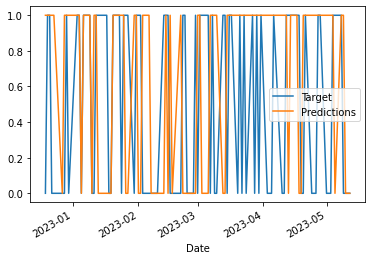

In [17]:
combined.plot()

In [23]:
# make step = 100
# backtesting algorithm
# start = 1000
# step = 20
def backtest(data, model, predictors, start = 1000, step=20):
    predictions = []
    for i in range(start, data.shape[0], step):

        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()

        model.fit(train[predictors], train["Target"])

        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > 0.55] = 1
        preds[preds <= 0.55] = 0

        combined = pd.concat({"Target": test["Target"], "Predictions": preds}, axis=1)

        predictions.append(combined)

    predictions = pd.concat(predictions)
    return predictions

In [24]:
predictions["Predictions"].value_counts()

0.0    618
1.0    391
Name: Predictions, dtype: int64

In [25]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5421994884910486

In [26]:
weekly_mean = data.rolling(7).mean()
quarterly_mean = data.rolling(90).mean()
annual_mean = data.rolling(365).mean()

weekly_trend = data.shift(1).rolling(7).mean()["Target"]

In [27]:
data["weekly_mean"] = weekly_mean["Close"] / data["Close"]
data["quarterly_mean"] = quarterly_mean["Close"] / data["Close"]
data["annual_mean"] = annual_mean["Close"] / data["Close"]

data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]
data["weekly_trend"] = weekly_trend

data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]
full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "weekly_trend", "open_close_ratio", "high_close_ratio", "low_close_ratio"]

In [28]:
predictions = backtest(data.iloc[365:], model, full_predictors)

In [29]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5077720207253886

In [30]:
predictions["Predictions"].value_counts()

0.0    451
1.0    193
Name: Predictions, dtype: int64

In [31]:
combined

,Target,Predictions
Date,,
2023-05-02 00:00:00-04:00,0.0,0.0
2023-05-03 00:00:00-04:00,0.0,1.0
2023-05-04 00:00:00-04:00,1.0,1.0
2023-05-05 00:00:00-04:00,1.0,0.0
2023-05-08 00:00:00-04:00,1.0,0.0
2023-05-09 00:00:00-04:00,0.0,1.0
2023-05-10 00:00:00-04:00,0.0,0.0
2023-05-11 00:00:00-04:00,0.0,0.0
2023-05-12 00:00:00-04:00,0.0,0.0
